# Project 2 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2023년 8월 10일 (목) 자정
- 구현 사항:
  - 성능이 잘 나오도록 [3. Feature Extraction](#3.-Feature-Extraction) 셀의 `extract_features` 함수 수정
  - [4. Classifiers](#4.-Classifiers) 셀에 5가지 분류기들을 구현
- 제출 파일: 출력이 포함된 `Project2.ipynb` (여러 번 제출시 마지막 버전을 사용)
- 제출 방법: `X조 ML Project 2` 제목으로 `ta_ml@hcs.snu.ac.kr`에 이메일 제출
- 점수 비중: 전체의 30%


### 채점 기준 [총 100점]
1. `LRClassifier`, `LDAClassifier`, `RFClassifier`, `BClassifier`, `SVMClassifier` 각 분류기당 [+20점]
  1. 수행 [+15점] : [5. Cross-validation with Subjects](#5.-Cross-validation-with-Subjects) 셀이 잘 수행되어야 하고, 분류기들은 각각 아래 주어진 방식으로 분류를 수행해야 합니다.
      - `LRClassifier` : Logistic Regression
      - `LDAClassifier` : Linear Discriminant Analysis
      - `RFClassifier` : Random Forest
      - `BClassifier` : Boosting with Decision Tree
      - `SVMClassifier` : Support Vector Machines
  2. 성능 [+5점]
    - 주어지지 않은 별개의 테스트 데이터를 이용해 각 분류기의 성능을 평가합니다. 각 분류기마다 팀별 상대적 성능을 고려해서 0점 ~ 5점 사이로 정해집니다. 팀별 성능을 점수로 변환하는 과정은 아래 코드를 참고해주세요.

    ```python
    import numpy as np
    from scipy import stats

    # Assume there are 5 teams. Example for single classifier.
    macro_f1_score_of_each_team = [0.9, 0.8, 0.5, 0.6, 0.65]

    # 1. Standardize f1 scores
    zscore = stats.zscore(macro_f1_score_of_each_team)
    # 2. Convert standardized f1 scores to 0 ~ 5 points
    score = 5 * (zscore - np.min(zscore)) / (np.max(zscore) - np.min(zscore))

    print(score)  # score = [5, 3.75, 0, 1.25, 1.875]
    ```

2. 띄어쓰기, 주석, Data Plotting 등 실행과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 [3. Feature Extraction](#3.-Feature-Extraction), [4. Classifiers](#4.-Classifiers) 두 부분만 수정하여야 합니다. [-50점]


### 참고 사항
- 이전 성능이 좋았던 팀들의 경우 각 분류기들의 Cross-validation macro F1 score는 0.65 정도 나왔습니다.

---
## 목차
1. [Project Overview](#1.-Project-Overview)
2. [Data Preparation](#2.-Data-Preparation)
3. [Feature Extraction](#3.-Feature-Extraction)
4. [Classifiers](#4.-Classifiers)
5. [Cross-validation with Subjects](#5.-Cross-validation-with-Subjects)

### 1. Project Overview
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### Import libraries

In [2]:
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
%matplotlib inline

### 2. Data Preparation
#### 2.1. Data Load
- 각 샘플은 X, Y, Subject로 이루어져 있습니다.
  - X: 가속도계의 3축 데이터
    - (500, 3) 형태의 `np.ndarray`
    - 5초 동안 100Hz로 3축 데이터를 모아 (500, 3) shape를 가지고 있습니다.
  - Y: 실험자의 행동
    - `str`
    - e.g. `walking`, `running`, ...
  - Subject: 해당 샘플을 수집한 실험자의 ID
    - `int`

In [3]:
def load_data(local=True):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    X        = np.stack(df['Data'])
    Y        = np.stack(df['Motion'])
    Subjects = np.stack(df['Subject'])

    return X, Y, Subjects

In [4]:
X, Y, Subjects = load_data(local=False)

print(f'X: {X.shape}  Y: {Y.shape}  Subjects: {Subjects.shape}')
print(f'Motions: {sorted(set(Y))}')
print(f'Subjects: {sorted(set(Subjects))}')

X: (13940, 500, 3)  Y: (13940,)  Subjects: (13940,)
Motions: ['Nordic walking', 'ascending stairs', 'cycling', 'descending stairs', 'ironing', 'lying', 'rope jumping', 'running', 'sitting', 'standing', 'vacuum cleaning', 'walking']
Subjects: [3, 4, 5, 6, 7, 8, 9]


#### 2.2. Plotting a Data Sample

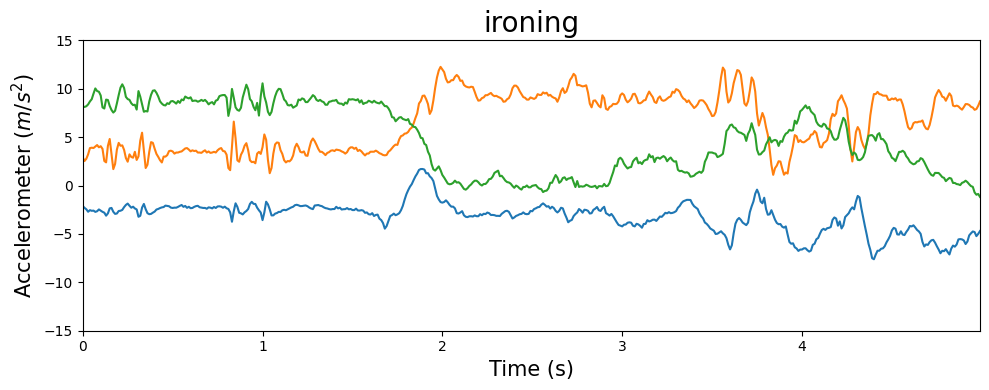

In [5]:
FPS = 100

X_sample, Y_sample = X[0], Y[0]
time_stamps = np.arange(0, len(X_sample)) / FPS


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time_stamps, X_sample)

ax.set_title(Y_sample, fontsize=20)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)
ax.set_xlim(min(time_stamps), max(time_stamps))
ax.set_ylim(-15, 15)

fig.tight_layout()
fig.show()

### (+) More plotting

Nordic walking
max: [ 47.631 155.257  67.009],                min: [ -49.741 -104.301  -25.516],                avg: [-4.003  4.726  2.398]
ascending stairs
max: [30.564 35.812 24.817],                min: [-48.524 -48.62  -34.205],                avg: [-8.931  3.333  1.626]
cycling
max: [ 60.913  52.964 116.977],                min: [-106.527  -52.304  -55.964],                avg: [-5.75   1.777  6.935]
descending stairs
max: [ 23.948  50.133 141.1  ],                min: [-50.78  -37.669 -18.13 ],                avg: [-6.302  2.248  4.067]
ironing
max: [19.309 32.933 41.331],                min: [-44.881 -30.282 -18.059],                avg: [-3.75   3.353  5.198]
lying
max: [21.033 44.433 42.539],                min: [-20.044 -19.506 -12.361],                avg: [3.382 1.788 7.045]
rope jumping
max: [ 20.192  65.43  157.76 ],                min: [-66.223 -81.681 -38.042],                avg: [-4.127  2.29  -0.544]
running
max: [ 42.892 155.699  49.77 ],                min: [-145.3

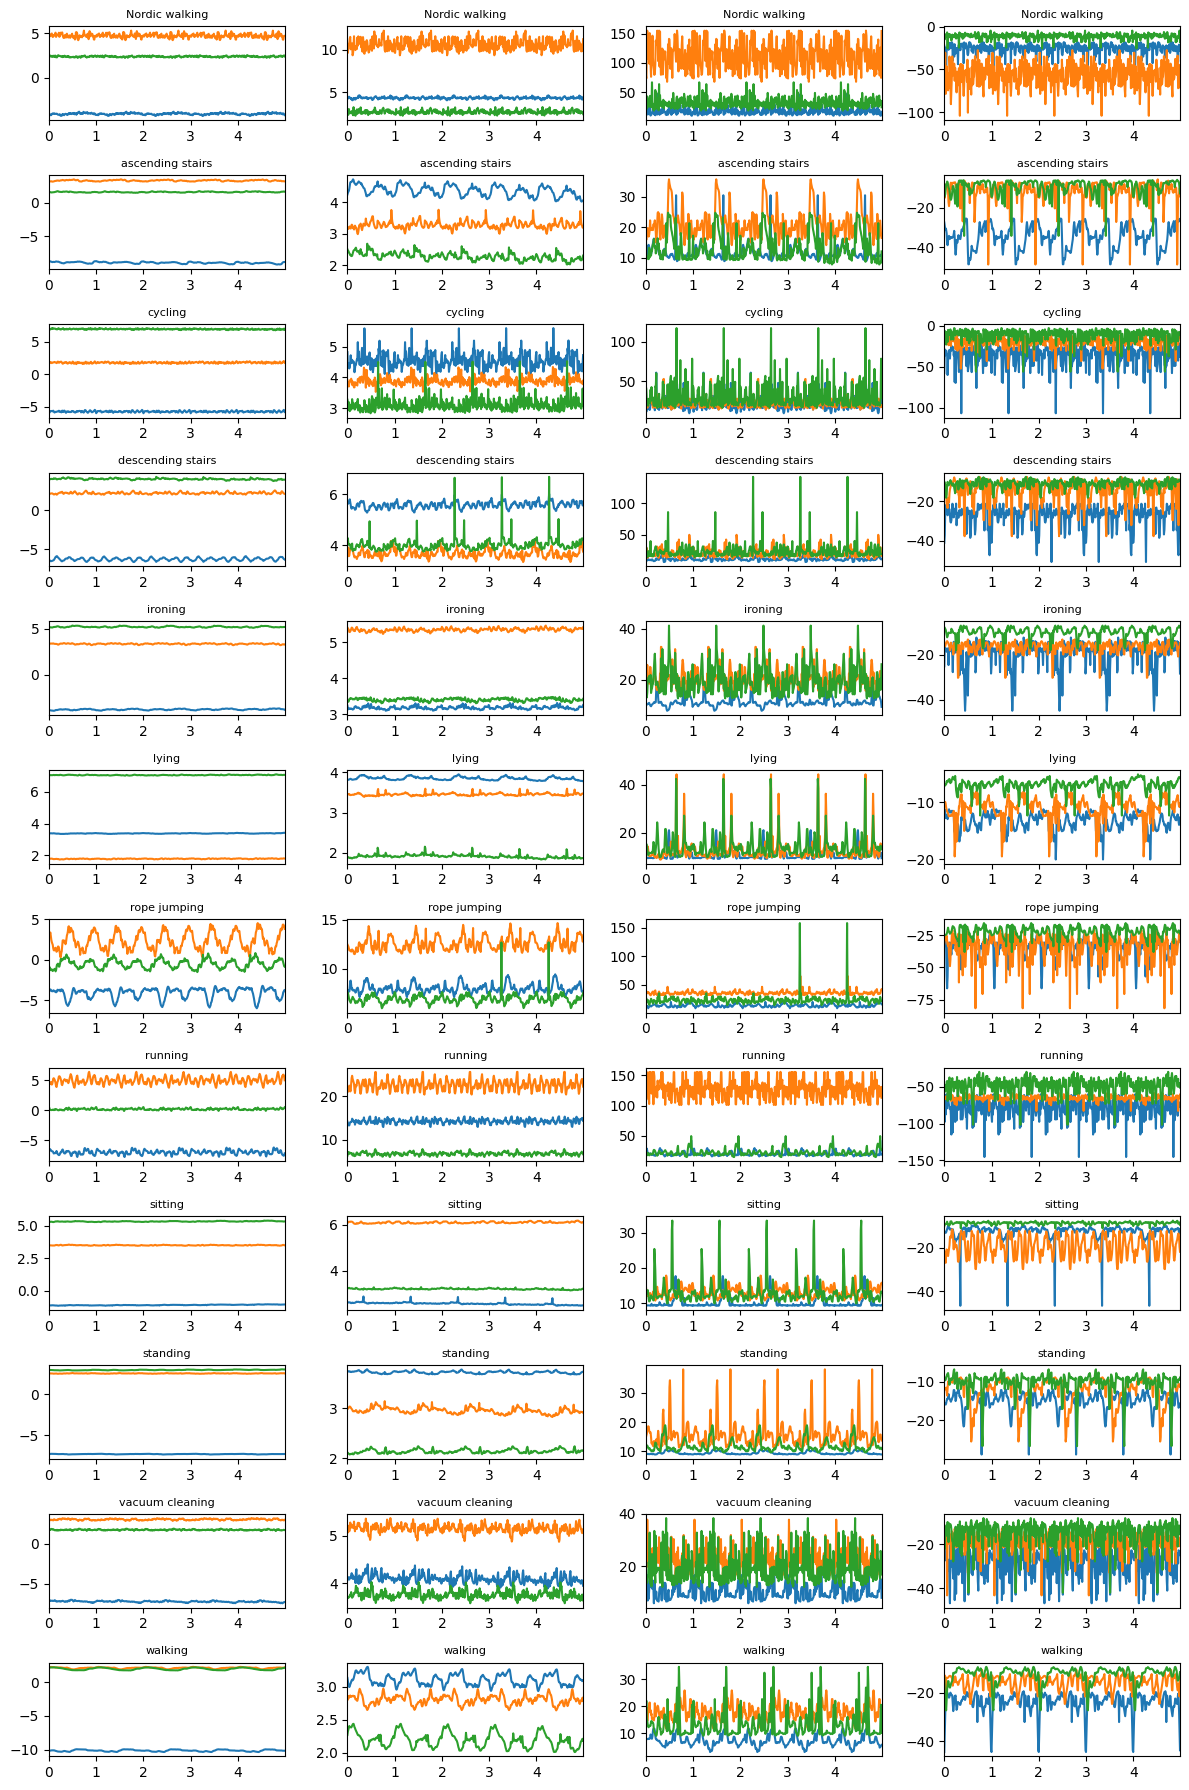

In [24]:
def pp_data(data, label, groups):
  fig = plt.figure(figsize=(12,18))
  time_stamps = np.arange(0, 500) / 100
  plot_case = 4

  for i, n in enumerate(sorted(set(label))):
    sorted_data = data[np.where(label == n)]
    sorted_mean = np.mean(sorted_data, axis=0)
    sorted_std = np.std(sorted_data, axis=0)
    sorted_max =  np.max(sorted_data, axis=0)
    sorted_min = np.min(sorted_data, axis=0)

    print(f'{n}')
    print(f"max: {np.round(np.max(sorted_max, axis=0),3)},{' ':>4}\
            min: {np.round(np.min(sorted_min, axis=0),3)},{' ':>4}\
            avg: {np.round(np.mean(sorted_mean, axis=0),3)}")

    sorted_list = [sorted_mean, sorted_std, sorted_max, sorted_min]
    for c, s in enumerate(sorted_list):
      ax = plt.subplot(12, plot_case, (i*plot_case)+(c+1))
      ax.plot(time_stamps, s)
      ax.set_title(n, fontsize=8)
      ax.set_xlim(min(time_stamps), max(time_stamps))
      # ax.set_ylim(-15, 15)


  fig.tight_layout()
  fig.show()

pp_data(X, Y, Subjects)

### 3. Feature Extraction
#### TODO: `extract_features(X_sample)` 함수 구현
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 코드에서는 Time domain의 mean, std 와 Frequency domain의 dominant frequency를 뽑고 있습니다.
- xyz축별 특성 뿐만 아니라 xyz축의 값을 합쳐서 사용해보셔도 좋습니다.
- 어느 정도 성능이 나온 이후에는 Confusion Matrix를 그려보면서 헷갈리는 동작들을 구분할 수 있는 특성들을 추가하면 성능을 높일 수 있습니다.
- 너무 많은 특성들을 사용하실 경우 Cross Validation 결과는 좋지만 Test 결과가 안좋을 수 있습니다.
- 아래 특성들은 Human Activity Recognition에서 많이 사용되는 특성들입니다.
  - Time Domain
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

In [25]:
from scipy.stats import entropy

def extract_features(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    assert X_sample.shape == (500, 3)

    #################### TODO: Extract more features ####################

    # Extract time domain features
    X_time = X_sample
    mean = np.mean(X_time, axis=0)
    std = np.std(X_time, axis=0)
    min = np.min(X_time, axis=0)
    max = np.max(X_time, axis=0)

    # correlated axis
    diff_xy = mean[0] - mean[1]
    diff_yz = mean[1] - mean[2]
    diff_zx = mean[2] - mean[0]

    # radians
    cos_x = np.mean(np.cos(X_time / 0.05 * 2 * np.pi), axis=0)
    sin_x = np.mean(np.sin(X_time / 0.05 * 2 * np.pi), axis=0)

    # Extract frequency domain features
    X_freq = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    dominant_freq = np.argmax(X_freq)
    fft_mean = np.mean(X_freq, axis=0)
    fft_std = np.std(X_freq, axis=0)
    v, c = np.unique(X_freq, return_counts=True)
    ent = entropy(c)

    fft_diff_xy = fft_mean[0] - fft_mean[1]
    fft_diff_yz = fft_mean[1] - fft_mean[2]
    fft_diff_zx = fft_mean[2] - fft_mean[0]

    # Concatenate features
    features = np.hstack([
        mean,
        std,
        min,
        max,
        dominant_freq,
        ent,
        fft_mean,
        fft_std,
        diff_xy,
        diff_yz,
        diff_zx,
        cos_x,
        sin_x,
        fft_diff_xy,
        fft_diff_yz,
        fft_diff_zx
    ])

    ######################################################################

    assert features.ndim == 1
    return features

In [29]:
# Extract features for multiple samples
X_features = np.array([
    extract_features(X_sample)
    for X_sample in X
])
print(X_features.shape)

(13940, 32)


### 4. Classifiers
#### TODO: `LRClassifier`, `LDAClassifier`, `RFClassifier`, `BClassifier`, `SVMClassifier` 5가지 Classifier 구현
- 아래 링크에서 `sklearn`이 제공하는 전처리기 목록을 확인하실 수 있습니다.
  - [sklearn.preprocessing documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
- 자세한 튜닝 방법은 `CrossValidation.ipynb`를 참고해주세요.
- `sklearn` 외의 라이브러리를 이용하셔도 됩니다.
- 아래는 KNN을 활용한 예시 Classifier입니다.

```python
# Example KNNClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


KNNClassifier = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', KNeighborsClassifier(n_neighbors=10)),
])
```

In [30]:
#################### TODO: Implement your own classifiers ####################
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

LRClassifier = Pipeline([
    ('normalizer', StandardScaler()),
    ('pca', PCA()),
    ('classifier', LogisticRegression(solver='saga', max_iter=1000)),
])

LDAClassifier = None
RFClassifier = None
BClassifier = None
SVMClassifier = None
##############################################################################

### 5. Cross-validation with Subjects

In [31]:
for clf in [LRClassifier]:
    scores = cross_val_score(
        clf,
        X_features, Y,
        groups=Subjects,        # Provide subjects for subject-wise cross-validation
        cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
        scoring='f1_macro',     # Scoring with macro F1 score
        n_jobs=-1,              # Enable multiprocessing
        verbose=10,             # Print processing logs
    )
    print(np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:  1.6min remaining:   37.7s


0.5250276498485479


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  2.0min finished


### (+) Feature Selection and Hyperparameter Tuning
#### clf.cv_results_keys()


In [10]:
from sklearn.preprocessing import FunctionTransformer

def select_features(features, indices=None):
    if indices is None:
        indices = [i for i in range(features.shape[1])]
    return features[:, indices]

feature_selector = FunctionTransformer(select_features)
feature_selector.get_params()

{'accept_sparse': False,
 'check_inverse': True,
 'feature_names_out': None,
 'func': <function __main__.select_features(features, indices=None)>,
 'inv_kw_args': None,
 'inverse_func': None,
 'kw_args': None,
 'validate': False}

In [11]:
LRTuning = Pipeline([
    ('feature_selector', FunctionTransformer(select_features)),
    ('LR', LRClassifier)
])

LDAClassifier = None
RFClassifier = None
BClassifier = None
SVMClassifier = None
##############################################################################

In [12]:
modelList = [LRTuning]

for m in modelList:
  display(m.get_params())
  print('--------------------------------------------------------------------------')
  display(m.get_params().keys())

{'memory': None,
 'steps': [('feature_selector',
   FunctionTransformer(func=<function select_features at 0x7bd6eb118940>)),
  ('LR',
   Pipeline(steps=[('normalizer', StandardScaler()), ('pca', PCA()),
                   ('classifier',
                    LogisticRegression(max_iter=1000, solver='saga'))]))],
 'verbose': False,
 'feature_selector': FunctionTransformer(func=<function select_features at 0x7bd6eb118940>),
 'LR': Pipeline(steps=[('normalizer', StandardScaler()), ('pca', PCA()),
                 ('classifier',
                  LogisticRegression(max_iter=1000, solver='saga'))]),
 'feature_selector__accept_sparse': False,
 'feature_selector__check_inverse': True,
 'feature_selector__feature_names_out': None,
 'feature_selector__func': <function __main__.select_features(features, indices=None)>,
 'feature_selector__inv_kw_args': None,
 'feature_selector__inverse_func': None,
 'feature_selector__kw_args': None,
 'feature_selector__validate': False,
 'LR__memory': None,
 'LR_

--------------------------------------------------------------------------


dict_keys(['memory', 'steps', 'verbose', 'feature_selector', 'LR', 'feature_selector__accept_sparse', 'feature_selector__check_inverse', 'feature_selector__feature_names_out', 'feature_selector__func', 'feature_selector__inv_kw_args', 'feature_selector__inverse_func', 'feature_selector__kw_args', 'feature_selector__validate', 'LR__memory', 'LR__steps', 'LR__verbose', 'LR__normalizer', 'LR__pca', 'LR__classifier', 'LR__normalizer__copy', 'LR__normalizer__with_mean', 'LR__normalizer__with_std', 'LR__pca__copy', 'LR__pca__iterated_power', 'LR__pca__n_components', 'LR__pca__n_oversamples', 'LR__pca__power_iteration_normalizer', 'LR__pca__random_state', 'LR__pca__svd_solver', 'LR__pca__tol', 'LR__pca__whiten', 'LR__classifier__C', 'LR__classifier__class_weight', 'LR__classifier__dual', 'LR__classifier__fit_intercept', 'LR__classifier__intercept_scaling', 'LR__classifier__l1_ratio', 'LR__classifier__max_iter', 'LR__classifier__multi_class', 'LR__classifier__n_jobs', 'LR__classifier__penalty'

In [13]:
LRTuning.set_params(
    LR__classifier__multi_class = {'multinomial'},
    LR__classifier__class_weight = {'balanced'}
)

Pipeline(steps=[('feature_selector',
                 FunctionTransformer(func=<function select_features at 0x7bd6eb118940>)),
                ('LR',
                 Pipeline(steps=[('normalizer', StandardScaler()),
                                 ('pca', PCA()),
                                 ('classifier',
                                  LogisticRegression(class_weight={'balanced'},
                                                     max_iter=1000,
                                                     multi_class={'multinomial'},
                                                     solver='saga'))]))])

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "LR__classifier__multi_class": ['multinomial'],
    "LR__classifier__class_weight": ['balanced']
}


for clf in modelList:
    gscv = GridSearchCV(
        estimator = clf,
        param_grid = param_grid,
        scoring='f1_macro',     # Scoring with macro F1 score
        cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
        n_jobs=-1,              # Enable multiprocessing
        verbose=10,
    )
    gscv.fit(X_features, Y, groups=Subjects)
    print(f'Best Alpha: {gscv.best_params_}, Best score: {gscv.best_score_}')

Fitting 7 folds for each of 1 candidates, totalling 7 fits


KeyboardInterrupt: ignored